The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


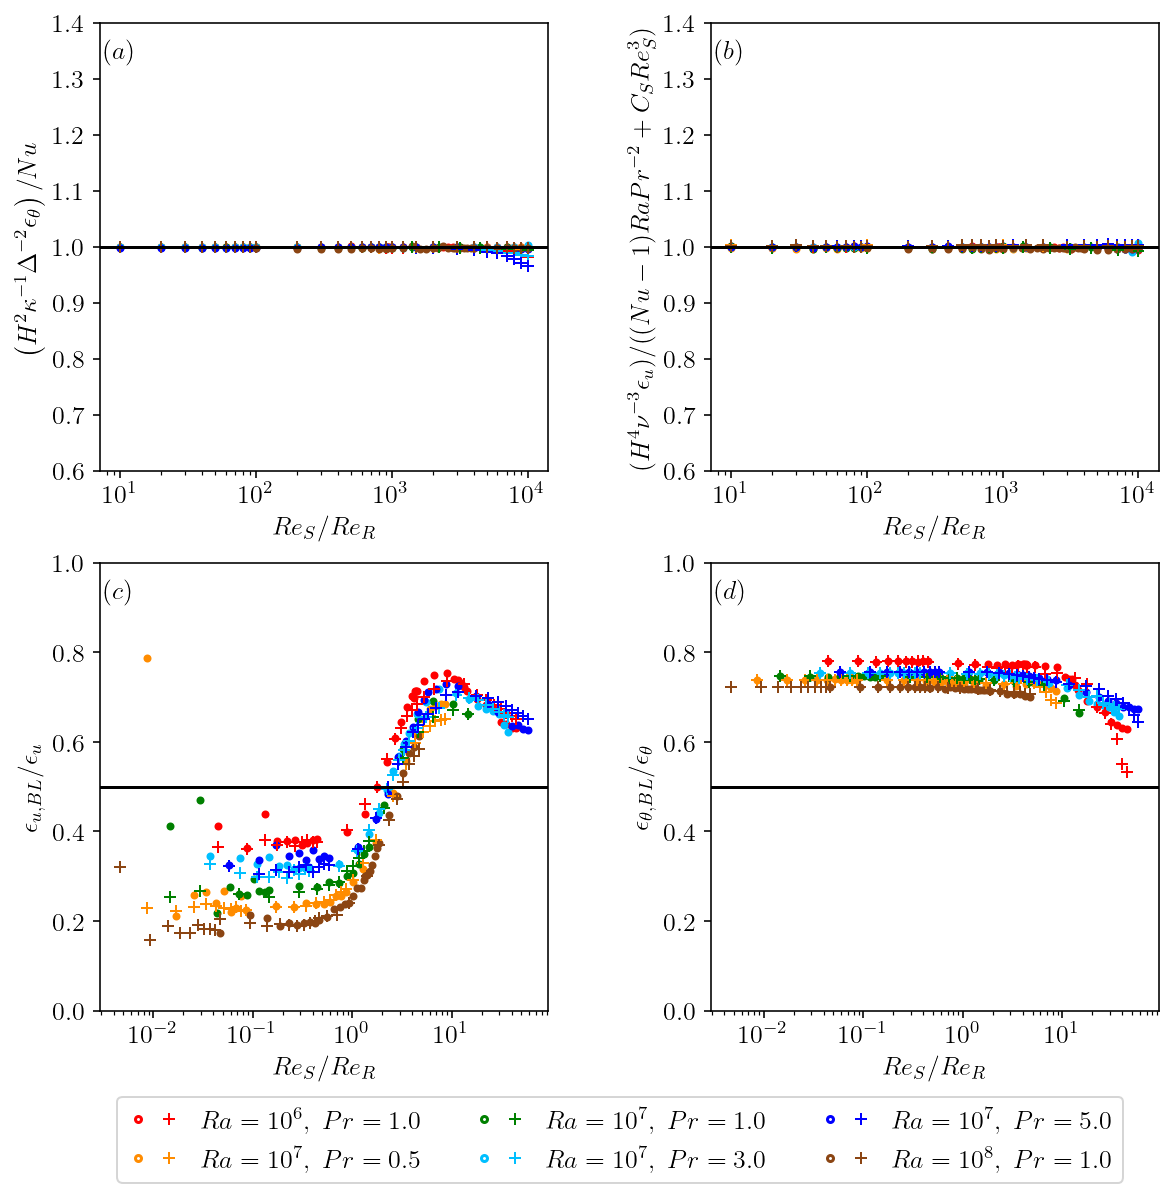

In [5]:
import os
import numpy as np
import scipy.interpolate as intp
import scipy.integrate as intg
import h5py
import matplotlib.pyplot as pl
from matplotlib import rc
from matplotlib.legend_handler import HandlerTuple

rc('font',**{'family':'STIXGeneral','serif':['stix'],'size':13})
rc('text', usetex=True)

def ISRE(foldername):
    if (foldername[:3]=='Re_'):
        return(True)
    else:
        return(False)

def INTG_PROFILE(xc,diss,a,b):

    xm = 0.5*(xc[1:] + xc[:-1])
    diss = intp.splrep(xm,diss)
    result = intp.splint(a,b,diss)

    return(result)

Case_list = [
    [
        '../raw_data/CRB/Ra1E+06_Pr1E+00',
        '../raw_data/CRB/Ra1E+07_Pr5E-01',
        '../raw_data/CRB/Ra1E+07_Pr1E+00',
        '../raw_data/CRB/Ra1E+07_Pr3E+00',
        '../raw_data/CRB/Ra1E+07_Pr5E+00',
        '../raw_data/CRB/Ra1E+08_Pr1E+00'
    ],
    [
        '../raw_data/PRB/Ra1E+06_Pr1E+00',
        '../raw_data/PRB/Ra1E+07_Pr5E-01',
        '../raw_data/PRB/Ra1E+07_Pr1E+00',
        '../raw_data/PRB/Ra1E+07_Pr3E+00',
        '../raw_data/PRB/Ra1E+07_Pr5E+00',
        '../raw_data/PRB/Ra1E+08_Pr1E+00'
    ]
]

Case_colors = ['r','darkorange','g','deepskyblue','b','saddlebrown']
Case_markers = ['.','+']
Case_types = ['sheared','channel']
Case_labels = ['$Ra=10^6, \ Pr=1.0$','$Ra=10^7, \ Pr=0.5$','$Ra=10^7, \ Pr=1.0$','$Ra=10^7, \ Pr=3.0$','$Ra=10^7, \ Pr=5.0$','$Ra=10^8, \ Pr=1.0$']

fig,axs = pl.subplots(2,2,figsize=(8.5,7.5),constrained_layout=True)

for i,(Case_set,Case_type,Case_marker) in enumerate(zip(Case_list,Case_types,Case_markers)):
    for j,(Case,Case_color,Case_label) in enumerate(zip(Case_set,Case_colors,Case_labels)):
        
        stafield = h5py.File('../raw_data/RBP/{}/stafield_master.h5'.format(Case[-15:]),'r')
        
        Ra    = stafield['Rayleigh Number'][0]
        Pr    = stafield['Prandtl Number'][0]

        nueff = (Pr/Ra)**0.5
        kpeff = (Pr*Ra)**-0.5
            
        t_avg = stafield['temp_m1'][0]
        
        xc    = stafield['xc'][:]
        xm    = stafield['xm'][:]
        xe    = np.pad(xm,(1,1),'constant',constant_values=(0,1))
        dx    = xc[1:] - xc[:-1]

        tp_m1 = stafield['temp_m1'][:]/t_avg
        tp_m1 = np.pad(tp_m1,(0,1),'constant',constant_values=0)
        tp_m1 = tp_m1 - 0.5
        tp_m1 = 0.5*(tp_m1 - np.flip(tp_m1))

        tp_xx = np.gradient(tp_m1,xc,edge_order=2)
        N0    = abs(tp_xx[0])
        
        vy_m2 = stafield['vy_m2'][:]/t_avg
        vy_m2 = np.pad(vy_m2,(1,1),'constant',constant_values=0)
        vy_m2 = 0.5*(vy_m2 + np.flip(vy_m2))
        
        vz_m2 = stafield['vz_m2'][:]/t_avg
        vz_m2 = np.pad(vz_m2,(1,1),'constant',constant_values=0)
        vz_m2 = 0.5*(vz_m2 + np.flip(vz_m2))
        
        vh_m2 = vy_m2 + vz_m2
        
        vh_m1 = (vh_m2**0.5)
        vh_mm = np.max(vh_m1[xe<0.5])
        R0    = vh_mm/nueff
        
        vh_xx = np.gradient(vh_m1,xe,edge_order=2)
        C0    = 2*nueff*vh_xx[0]/(vh_mm**2)

        Re_list = sorted(filter(ISRE,os.listdir(Case)))

        for Re_dir in Re_list:

            try:
                stafield = h5py.File('{}/{}/stafield_master.h5'.format(Case,Re_dir),'r')
            except:
                print("Cannot find stafield : ",Case,Re_dir)
                continue

            try:
                n_avg = stafield['averaging_samples'][0]
            except:
                n_avg = stafield['averaging_time'][0]

            t_avg = stafield['temp_m1'][0]

            Ra    = stafield['Rayleigh Number'][0]
            Pr    = stafield['Prandtl Number'][0]

            nueff = (Pr/Ra)**0.5
            kpeff = (Pr*Ra)**-0.5

            xc    = stafield['xc'][:]
            xm    = stafield['xm'][:]
            xe    = np.pad(xm,(1,1),'constant',constant_values=(0,1))
            dx    = xc[1:] - xc[:-1]
                
            tp_m1 = stafield['temp_m1'][:]/t_avg
            tp_m1 = np.pad(tp_m1,(0,1),'constant',constant_values=0)
            tp_m1 = tp_m1 - 0.5
            tp_m1 = 0.5*(tp_m1 - np.flip(tp_m1))

            tp_xx = np.gradient(tp_m1,xc,edge_order=2)
            Nu    = abs(tp_xx[0])
            tbl_m = 0.5/Nu

            vx_m2 = stafield['vx_m2'][:]/t_avg
            vx_m2 = np.pad(vx_m2,(0,1),'constant',constant_values=0)
            vx_m2 = 0.5*(vx_m2 + np.flip(vx_m2))
            vx_m2 = 0.5*(vx_m2[1:] + vx_m2[:-1])
            vx_m2 = np.pad(vx_m2,(1,1),'constant',constant_values=0)

            vy_m2 = stafield['vy_m2'][:]/t_avg
            vy_m2 = np.pad(vy_m2,(1,1),'constant',constant_values=0)
            vy_m2 = 0.5*(vy_m2 + np.flip(vy_m2))

            if (i==0):

                Re = stafield['Wall Reynolds Number'][0]
                Uu = stafield['Wall Velocity'][0]

                vz_m1 = stafield['vz_m1'][:]/t_avg
                vz_m1 = np.pad(vz_m1,(1,1),'constant',constant_values=(-Uu,Uu))
                vz_m1 = 0.5*(vz_m1 - np.flip(vz_m1))

                vz_m2 = stafield['vz_m2'][:]/t_avg
                vz_m2 = np.pad(vz_m2,(1,1),'constant',constant_values=Uu**2)
                vz_m2 = 0.5*(vz_m2 + np.flip(vz_m2))

                vh_m2 = vy_m2 + vz_m2 + Uu**2 + 2*Uu*vz_m1

                Uc    = Uu
            
            if (i==1):

                Re = stafield['Bulk Reynolds Number'][0]
                Uu = stafield['Bulk Velocity'][0]

                vz_m1 = stafield['vz_m1'][:]/t_avg
                vz_m1 = np.pad(vz_m1,(1,1),'constant',constant_values=0)
                vz_m1 = 0.5*(vz_m1 + np.flip(vz_m1))

                vz_m2 = stafield['vz_m2'][:]/t_avg
                vz_m2 = np.pad(vz_m2,(1,1),'constant',constant_values=0)
                vz_m2 = 0.5*(vz_m2 + np.flip(vz_m2))
            
                vh_m2 = vy_m2 + vz_m2

                Uc    = intp.interp1d(xe,vz_m1,kind='cubic')
                Uc    = Uc(0.5)

            vz_xx = np.gradient(vz_m1,xe,edge_order=2)
            kbl_s = Uu/vz_xx[0]
            Cs    = 2*nueff*vz_xx[0]/(Uu**2)
            
            vl_m2 = vh_m2 + vx_m2

            vh_m1 = (vh_m2**0.5)

            vh_mm = np.max(vh_m1[xe<0.5])
            vl_mm = (np.sum(vl_m2[1:-1]*dx))**0.5

            Re_h  = vh_mm/nueff
            Re_t  = vl_mm/nueff

            vh_xx = np.gradient(vh_m1,xe,edge_order=2)
            kbl_t = vh_mm/vh_xx[0]
            Ct    = 2*nueff*vh_xx[0]/(vh_mm**2)

            tdiss = stafield['dissth'][:]/n_avg
            kdiss = stafield['disste'][:]/n_avg

            tdiss = 0.5*(tdiss+np.flip(tdiss))
            kdiss = 0.5*(kdiss+np.flip(kdiss))

            tdtot  = INTG_PROFILE(xc,tdiss,0,1)
            kdtot  = INTG_PROFILE(xc,kdiss,0,1)

            tdblk = INTG_PROFILE(xc,tdiss,tbl_m,1-tbl_m)
            rtblk = tdblk/tdtot

            kdblk = INTG_PROFILE(xc,kdiss,kbl_s,1-kbl_s)
            rkblk = kdblk/kdtot

            G1 = (kdtot/(nueff**3))/(((Nu-1)*Ra/(Pr*Pr)) + (Cs*Re*Re*Re))
            G2 = tdtot/(kpeff*Nu)
            Rg = ((R0**2) + (Re**2))**0.5
            G3 = (kdblk/(nueff**3))/(Rg*R0*R0)

            axs[0,0].plot(Re,G2,marker=Case_marker,color=Case_color)
            axs[0,1].plot(Re,G1,marker=Case_marker,color=Case_color)

            axs[1,0].plot(Re/R0,1-rkblk,marker=Case_marker,color=Case_color)
            axs[1,1].plot(Re/R0,1-rtblk,marker=Case_marker,color=Case_color)

axs[0,0].set_xscale('log')
axs[0,0].axhline(1.0,color='k')
axs[0,0].set_ylim(0.6,1.4)
axs[0,0].set_xlabel(r'$Re_S/Re_R$')
axs[0,0].set_ylabel(r'$\left(H^2 \kappa^{-1} \Delta^{-2} \epsilon_{\theta} \right)/ Nu$')
axs[0,0].text(0.01,0.92,'$(a)$',transform=axs[0,0].transAxes)
axs[0,0].set_box_aspect(1)

axs[0,1].set_xscale('log')
axs[0,1].axhline(1.0,color='k')
axs[0,1].set_ylim(0.6,1.4)
axs[0,1].set_xlabel(r'$Re_S/Re_R$')
axs[0,1].set_ylabel(r'$ \bigl( H^4 \nu^{-3} \epsilon_{u} \bigr) / \bigl((Nu-1) Ra Pr^{-2} + C_S Re_S^3 \bigr)$')
axs[0,1].text(0.01,0.92,'$(b)$',transform=axs[0,1].transAxes)
axs[0,1].set_box_aspect(1)

axs[1,0].set_xscale('log')
axs[1,0].axhline(0.5,color='k')
axs[1,0].set_ylim(0,1)
axs[1,0].set_xlabel(r'$Re_S/Re_R$')
axs[1,0].set_ylabel(r'$\epsilon_{u,BL}/\epsilon_{u}$')
axs[1,0].text(0.01,0.92,'$(c)$',transform=axs[1,0].transAxes)
axs[1,0].set_box_aspect(1)

axs[1,1].set_xscale('log')
axs[1,1].axhline(0.5,color='k')
axs[1,1].set_ylim(0,1)
axs[1,1].set_xlabel(r'$Re_S/Re_R$')
axs[1,1].set_ylabel(r'$\epsilon_{\theta,BL}/\epsilon_{\theta}$')
axs[1,1].text(0.01,0.92,'$(d)$',transform=axs[1,1].transAxes)
axs[1,1].set_box_aspect(1)

h11, = axs[0,0].plot([],[],linestyle='',marker='.',markerfacecolor=(0,0,0,0),markeredgecolor='r',markeredgewidth=1.5)
h12, = axs[0,0].plot([],[],linestyle='',marker='+',markeredgecolor='r')
h21, = axs[0,0].plot([],[],linestyle='',marker='.',markerfacecolor=(0,0,0,0),markeredgecolor='darkorange',markeredgewidth=1.5)
h22, = axs[0,0].plot([],[],linestyle='',marker='+',markeredgecolor='darkorange')
h31, = axs[0,0].plot([],[],linestyle='',marker='.',markerfacecolor=(0,0,0,0),markeredgecolor='g',markeredgewidth=1.5)
h32, = axs[0,0].plot([],[],linestyle='',marker='+',markeredgecolor='g')
h41, = axs[0,0].plot([],[],linestyle='',marker='.',markerfacecolor=(0,0,0,0),markeredgecolor='deepskyblue',markeredgewidth=1.5)
h42, = axs[0,0].plot([],[],linestyle='',marker='+',markeredgecolor='deepskyblue')
h51, = axs[0,0].plot([],[],linestyle='',marker='.',markerfacecolor=(0,0,0,0),markeredgecolor='b',markeredgewidth=1.5)
h52, = axs[0,0].plot([],[],linestyle='',marker='+',markeredgecolor='b')
h61, = axs[0,0].plot([],[],linestyle='',marker='.',markerfacecolor=(0,0,0,0),markeredgecolor='saddlebrown',markeredgewidth=1.5)
h62, = axs[0,0].plot([],[],linestyle='',marker='+',markeredgecolor='saddlebrown')

Case_handles = [(h11,h12),(h21,h22),(h31,h32),(h41,h42),(h51,h52),(h61,h62)]
Case_labels = ['$Ra=10^6, \ Pr=1.0$','$Ra=10^7, \ Pr=0.5$','$Ra=10^7, \ Pr=1.0$','$Ra=10^7, \ Pr=3.0$','$Ra=10^7, \ Pr=5.0$','$Ra=10^8, \ Pr=1.0$']

pl.figlegend(handles=Case_handles,labels=Case_labels,handler_map={tuple: HandlerTuple(ndivide=None)},ncol=3,loc='lower center',bbox_to_anchor=(0.5,-0.1))
# pl.savefig('Diss.eps',bbox_inches='tight')
# pl.savefig('Diss.pdf',bbox_inches='tight')
# pl.savefig('Diss.png',bbox_inches='tight',dpi=300)
pl.show()
